In [1]:
from astropy import units as u
from astropy import time

import numpy as np
import pandas as pd
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
import plotly.io as pio
import matplotlib.pyplot as plt

In [2]:
pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris

In [3]:
solar_system_ephemeris.set("jpl")
asteroid="2006 SU49"
stay_time=20 #days
search_length=365*15 #days
start_date="2022-11-20 15:00"

In [4]:
date_launch = time.Time(start_date, scale="utc").tdb
date_arrival = date_launch+time.TimeDelta(180*u.day)
date_leave = date_arrival + time.TimeDelta(stay_time*u.day)
date_return = date_leave + time.TimeDelta(180*u.day)
date_final = date_return + time.TimeDelta(search_length*u.day)

In [5]:
asteroid_orbit=Orbit.from_sbdb(asteroid)

In [6]:
epochs = time_range(date_launch, end=date_final)
asteroid_ephem=Ephem.from_horizons(asteroid, epochs)

In [7]:
earth = Ephem.from_body(Earth, epochs)

In [8]:
# Initial data
data=[]

In [9]:
for i in range(search_length):
    date_launch_temp = date_launch + time.TimeDelta(i*u.day)
    date_arrival_temp = date_arrival + time.TimeDelta(i*u.day)
    date_leave_temp = date_leave + time.TimeDelta(i*u.day)
    date_return_temp = date_return + time.TimeDelta(i*u.day)
    
    # Solve for departure and target orbits
    ss_earth = Orbit.from_ephem(Sun, earth, date_launch_temp)
    ss_asteroid = Orbit.from_ephem(Sun, asteroid_ephem, date_arrival_temp)
    
    # Solve for the transfer maneuver
    asteroid_lambert = Maneuver.lambert(ss_earth, ss_asteroid)
    dv1=str(asteroid_lambert.get_total_cost()).split(' ')[0]
    
    #Return 
    ss_asteroid = Orbit.from_ephem(Sun, asteroid_ephem, date_leave_temp)
    ss_earth = Orbit.from_ephem(Sun, earth, date_return_temp)
    asteroid_lambert = Maneuver.lambert(ss_asteroid, ss_earth)
    dv2=str(asteroid_lambert.get_total_cost()).split(' ')[0]
    
    data.append((date_launch_temp.strftime("%Y-%M-%D"),dv1, dv2))

In [10]:
# # Get the transfer and final orbits
# ss_trans, ss_target = ss_earth.apply_maneuver(asteroid_lambert, intermediate=True)

In [11]:
df=pd.DataFrame(data)
df.columns=['launch_date', 'dv_to', 'dv_return']
df['dv_to']=pd.to_numeric(df['dv_to'])
df['dv_return']=pd.to_numeric(df['dv_return'])
df['launch_date']=df['launch_date'].str[8:]

In [12]:
dv_leo_to_e=2.44+0.68+0.09
dv_e_to_eml1=0.09+0.14+0.58
df['dv_total']=df['dv_to']+df['dv_return']+2*dv_e_to_eml1

Text(0.5, 0, 'Launch Date')

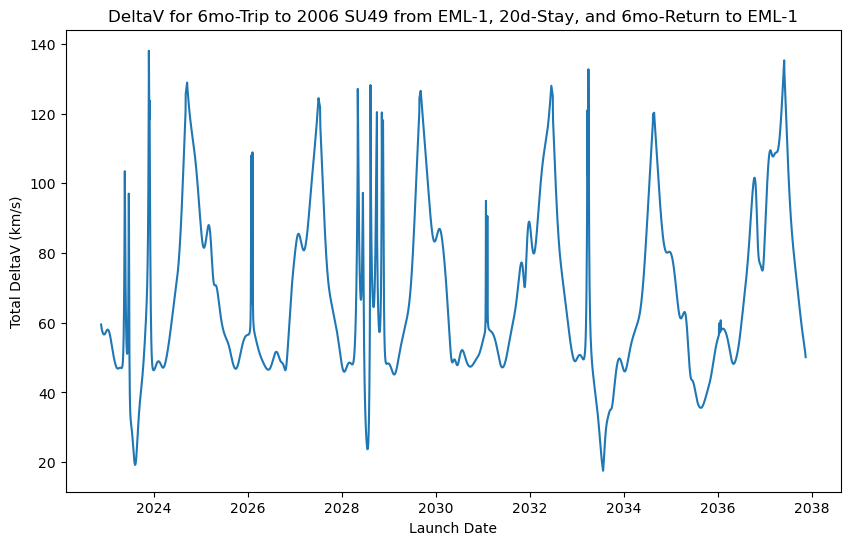

In [13]:
fig, ax= plt.subplots(1,1, figsize=[10,6])
ax.plot(pd.to_datetime(df['launch_date']), df['dv_total'])
ax.set_ylabel('Total DeltaV (km/s)')
ax.set_title(f'DeltaV for 6mo-Trip to {asteroid} from EML-1, 20d-Stay, and 6mo-Return to EML-1')
ax.set_xlabel('Launch Date')
#ax.set_ylim([3,30])

In [14]:
fig.autofmt_xdate()
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter("%m-%d-%Y")
datetimefmt = mdates.DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(datetimefmt)